In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts
import physically_informed_loss_functions as pilf

In [12]:
dev_train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')
test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

dev_only_x = dev_train_df[['Time (min)', 'Temp (C)']]
dev_only_y = dev_train_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_train = train_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_train = train_df[['PCE', 'VocL', 'Jsc', 'FF']]

x_test = test_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

In [14]:
print(x_train)

    Anneal_time  Anneal_temp  p1_fraction  p2_fraction  p3_fraction  \
0            15          100     0.379892     0.741510     0.042227   
1            15          100     0.299771     0.662438     0.354767   
2            15          100     0.122273     0.555842     0.907236   
3            30          100     0.019406     0.848362     0.504491   
4             5          100     1.000000     0.000000     0.384999   
5             5          100     0.483283     0.629028     0.076625   
6             5          100     0.495861     0.615346     0.080807   
7            15          125     0.519641     0.593236     0.081045   
8            15          125     0.026318     1.000000     0.182041   
9            15          125     0.423840     0.712891     0.017687   
10           15          125     0.390454     0.660425     0.187744   
11           30          125     0.081890     0.957086     0.164730   
12            5          125     0.232186     0.589974     0.630169   
13    

In [3]:
params = {
    'kernel' : ['poly', 'rbf'],
    'coef0' : np.logspace(-3, 3, 10),
    'degree' : np.arange(2, 34, step = 2),
    'gamma' : ['scale'],
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'tol' : [1e-3],
    'cache_size' : [500],
    'verbose' : [True]
}

svr_pce = GridSearchCV(SVR(), param_grid = params, verbose = 3, n_jobs = -1)
svr_voc = GridSearchCV(SVR(), param_grid = params, verbose = 3, n_jobs = -1)
svr_jsc = GridSearchCV(SVR(), param_grid = params, verbose = 3, n_jobs = -1)
svr_ff = GridSearchCV(SVR(), param_grid = params, verbose = 3, n_jobs = -1)

In [4]:
svr_pce.fit(x_train, y_train['PCE'])
svr_voc.fit(x_train, y_train['VocL'])
svr_jsc.fit(x_train, y_train['Jsc'])
svr_ff.fit(x_train, y_train['FF'])

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [6]:
pce_params = svr_pce.best_params_
voc_params = svr_voc.best_params_
jsc_params = svr_jsc.best_params_
ff_params = svr_ff.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

{'C': 100.0, 'cache_size': 500, 'coef0': 1, 'degree': 8, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001, 'verbose': True}
{'C': 0.1, 'cache_size': 500, 'coef0': 0.1, 'degree': 22, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001, 'verbose': True}
{'C': 1.0, 'cache_size': 500, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001, 'verbose': True}
{'C': 100.0, 'cache_size': 500, 'coef0': 0.1, 'degree': 6, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001, 'verbose': True}


In [7]:
pce_preds = svr_pce.predict(x_test)
voc_preds = svr_voc.predict(x_test)
jsc_preds = svr_jsc.predict(x_test)
ff_preds = svr_ff.predict(x_test)

In [9]:
mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.038277556052491904, mape = 21.42870156936386, r2 = -0.7257070889206745
mse = 3.060304783433671, mape = 118.21073307384317, r2 = -0.4176463317186534
mse = 0.0050737070741739415, mape = 7.629933456400605, r2 = 0.5865493338986214
mse = 0.05083210979743245, mape = 22.441189343826302, r2 = -0.48982901369743814


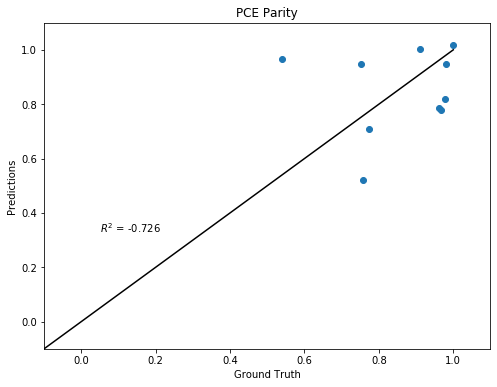

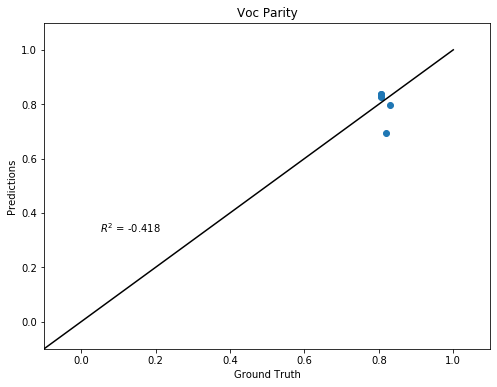

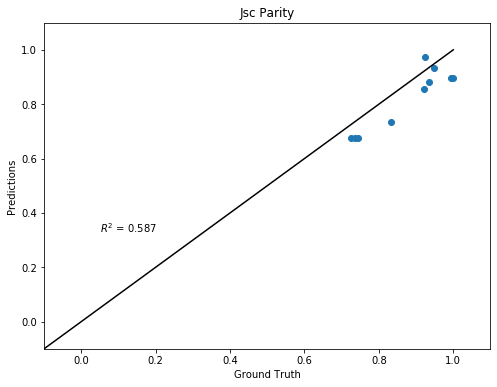

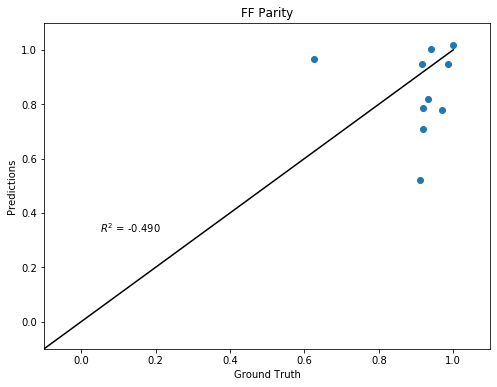

In [10]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()

# Device data only regression

In [4]:
params = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'coef0' : [0.1, 1, 10],
    'degree' : np.arange(2, 31, step = 1),
    'gamma' : ['scale'],
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
    'tol' : [1e-3, 1e-2],
    'cache_size' : [500],
    'verbose' :[3]
}

svr_pce = GridSearchCV(SVR(), param_grid = params, verbose = 5, n_jobs = -1)
svr_voc = GridSearchCV(SVR(), param_grid = params, verbose = 5, n_jobs = -1)
svr_jsc = GridSearchCV(SVR(), param_grid = params, verbose = 5, n_jobs = -1)
svr_ff = GridSearchCV(SVR(), param_grid = params, verbose = 5, n_jobs = -1)

svr_pce.fit(dev_only_x, dev_only_y['PCE'])
print('finished PCE')
svr_voc.fit(dev_only_x, dev_only_y['VocL'])
print('finished Voc')
svr_jsc.fit(dev_only_x, dev_only_y['Jsc'])
print('finished Jsc')
svr_ff.fit(dev_only_x, dev_only_y['FF'])
print('finished FF')

Fitting 5 folds for each of 2610 candidates, totalling 13050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 591 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  5.0min


KeyboardInterrupt: 

In [ ]:
pce_params = svr_pce.best_params_
voc_params = svr_voc.best_params_
jsc_params = svr_jsc.best_params_
ff_params = svr_ff.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

In [ ]:
%autoreload

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

In [ ]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()

----------------------------------------
# Testing and Development below here

----------------------------------------

In [68]:
svr = SVR(kernel = 'rbf', degree = 30, gamma = 'scale', coef0 = 0.1,
          C = 1e4, verbose = 2)

In [69]:
svr.fit(x_train, y_train['PCE'])

[LibSVM]

SVR(C=10000.0, cache_size=200, coef0=0.1, degree=30, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=2)

In [70]:
pce_preds = svr.predict(x_test)

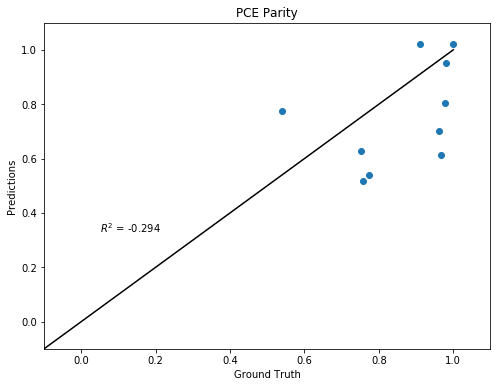

In [71]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()